In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler


2025-06-27 16:06:32.490176: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751040392.705009      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751040392.771793      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv("/kaggle/input/stock-market-dataset/stocks/AAPL.csv")

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400


In [4]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,9909.000000,9909.000000,9909.000000,9909.000000,9909.000000,9.909000e+03
mean,32.606849,32.936079,32.277560,32.618030,30.576570,8.582916e+07
std,58.415759,59.001576,57.883037,58.471899,56.746275,8.597195e+07
min,0.198661,0.198661,0.196429,0.196429,0.155638,3.472000e+05
25%,1.071429,1.089286,1.048571,1.071429,0.917643,3.304230e+07
50%,1.729286,1.758929,1.696429,1.732143,1.466154,5.766490e+07
75%,35.799999,36.265713,35.328571,35.761429,31.042374,1.069992e+08
max,324.739990,327.850006,323.350006,327.200012,327.200012,1.855410e+09


In [5]:
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
df = df.set_index('Date')
df = df[['Close']]

In [7]:
df.head()

,Close
Date,
1980-12-12,0.513393
1980-12-15,0.486607
1980-12-16,0.450893
1980-12-17,0.462054
1980-12-18,0.475446


In [8]:
# Scale the data
scaler = MinMaxScaler()
df['Close_scaled'] = scaler.fit_transform(df[['Close']])

<Axes: xlabel='Date'>

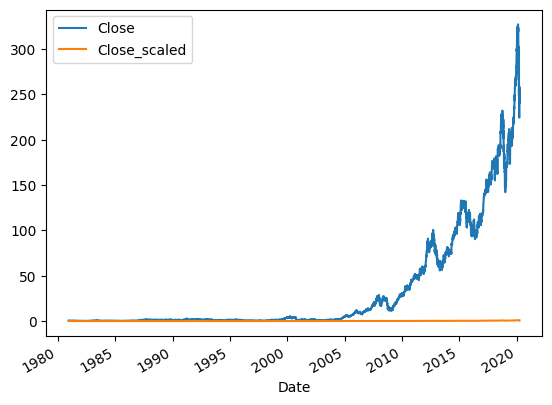

In [9]:
df.plot()

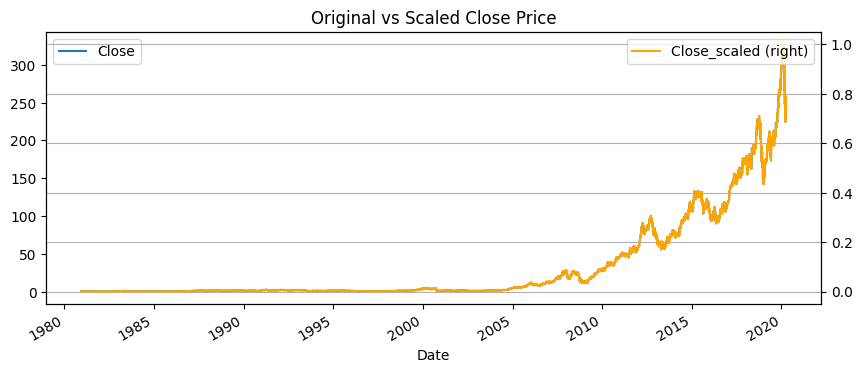

In [10]:
# Plot to confirm scaling
plt.figure(figsize=(10, 4))
ax = df['Close'].plot(label='Close')
df['Close_scaled'].plot(ax=ax, secondary_y=True, label='Close_scaled', color='orange')
ax.legend(loc='upper left')
ax.right_ax.legend(loc='upper right')
plt.title("Original vs Scaled Close Price")
plt.grid(True)
plt.show()

In [11]:
# Create windowed dataset
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=60):
    first_date = pd.to_datetime(first_date_str)
    last_date  = pd.to_datetime(last_date_str)
    target_date = first_date

    dates = []
    X, Y = [], []

    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)
        if len(df_subset) != n+1:
            break
        values = df_subset['Close_scaled'].to_numpy()
        x, y = values[:-1], values[-1]
        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_rows = dataframe.loc[target_date:].head(2)
        if len(next_rows) < 2:
            break
        target_date = next_rows.index[1]
        if target_date > last_date:
            break

    ret_df = pd.DataFrame({'Target Date': dates})
    X = np.array(X)
    for i in range(n):
        ret_df[f'Target-{n - i}'] = X[:, i]
    ret_df['Target'] = Y
    return ret_df



In [12]:
windowed_df = df_to_windowed_df(df, '2010-01-01', '2020-12-31', n=60)

In [13]:
def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()
    dates = df_as_np[:, 0]
    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
    Y = df_as_np[:, -1]
    return dates, X.astype(np.float32), Y.astype(np.float32)

In [14]:
dates, X, y = windowed_df_to_date_X_y(windowed_df)

In [15]:
# Split the data
total = len(dates)
split_80 = int(total * 0.8)
split_90 = int(total * 0.9)


In [16]:
X_train, y_train, dates_train = X[:split_80], y[:split_80], dates[:split_80]
X_val, y_val, dates_val = X[split_80:split_90], y[split_80:split_90], dates[split_80:split_90]
X_test, y_test, dates_test = X[split_90:], y[split_90:], dates[split_90:]

In [17]:
# Build the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(X.shape[1], 1)),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])
model.compile(loss='mse', optimizer='adam')
model.summary()

I0000 00:00:1751040695.517159      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

Epoch 1/10


I0000 00:00:1751040713.977984     113 cuda_dnn.cc:529] Loaded cuDNN version 90300


65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0206 - val_loss: 7.4926e-04
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.2803e-04 - val_loss: 7.3579e-04
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.1315e-04 - val_loss: 6.9213e-04
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0922e-04 - val_loss: 6.1307e-04
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0350e-04 - val_loss: 5.5100e-04
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0502e-04 - val_loss: 4.5518e-04
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.7670e-05 - val_loss: 4.2912e-04
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.1701e-05 - val_loss: 4.6334e-04
Epoch 9/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.4590e-05 - val_loss: 4.3050e-04
Epoch 10/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.9040e-05 - val_loss: 6.5806e-04


In [19]:
# Predict on all sets
y_train_pred = model.predict(X_train)
y_val_pred   = model.predict(X_val)
y_test_pred  = model.predict(X_test)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [20]:
# Inverse scale
y_train_inv = scaler.inverse_transform(y_train_pred).flatten()
y_val_inv   = scaler.inverse_transform(y_val_pred).flatten()
y_test_inv  = scaler.inverse_transform(y_test_pred).flatten()

In [21]:
y_train_orig = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_val_orig   = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
y_test_orig  = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

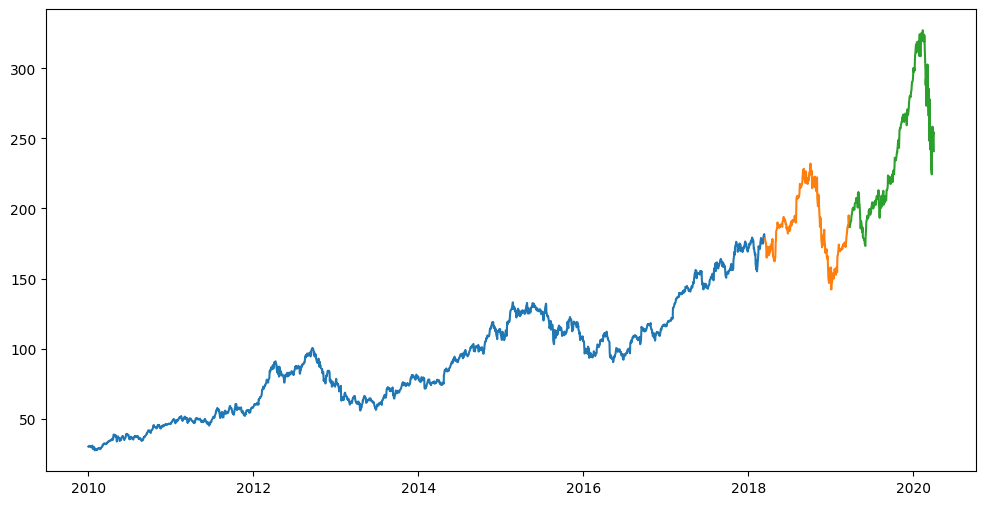

In [22]:
# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(dates_train, y_train_orig, label='Train Actual')
plt.plot(dates_val, y_val_orig, label='Val Actual')
plt.plot(dates_test, y_test_orig, label='Test Actual')

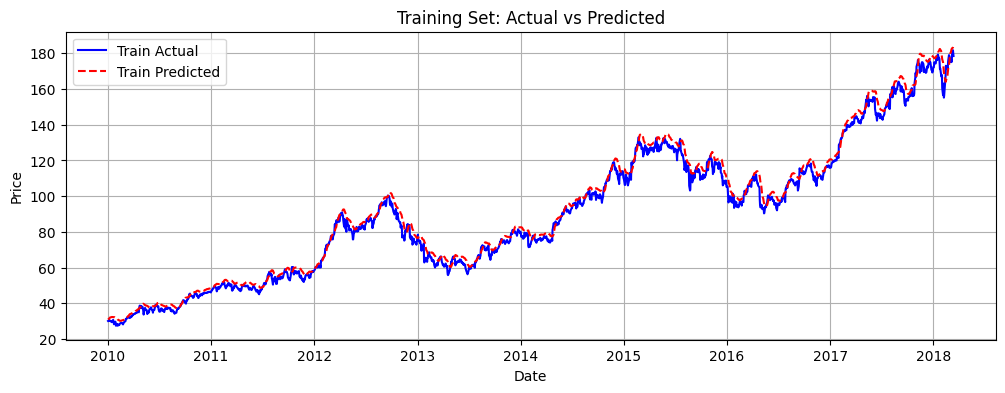

In [26]:
plt.figure(figsize=(12, 4))
plt.plot(dates_train, y_train_orig, label='Train Actual', color='blue')
plt.plot(dates_train, y_train_inv, '--', label='Train Predicted', color='red')
plt.title("Training Set: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

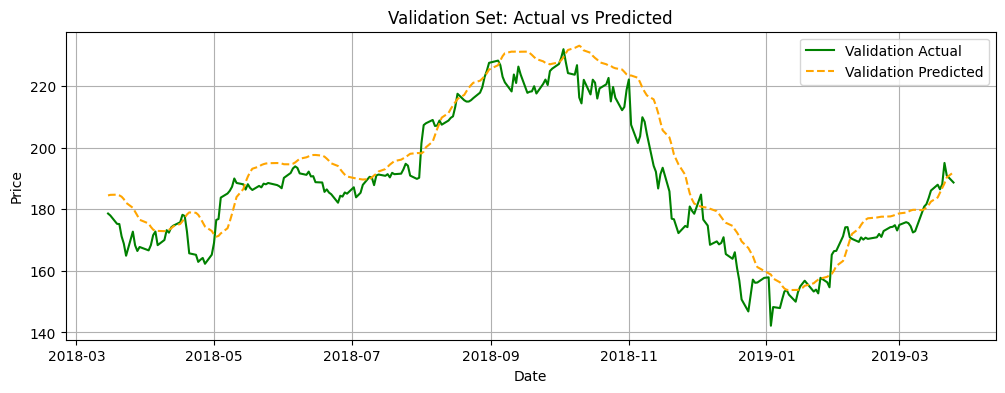

In [27]:
plt.figure(figsize=(12, 4))
plt.plot(dates_val, y_val_orig, label='Validation Actual', color='green')
plt.plot(dates_val, y_val_inv, '--', label='Validation Predicted', color='orange')
plt.title("Validation Set: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

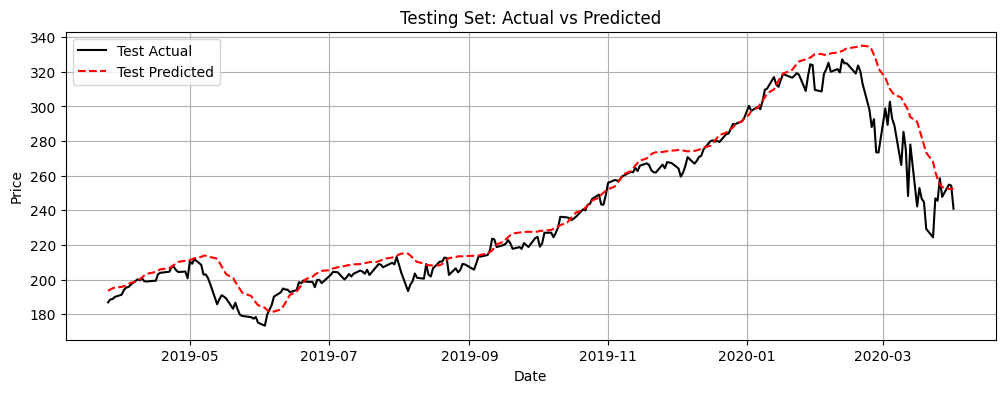

In [28]:
plt.figure(figsize=(12, 4))
plt.plot(dates_test, y_test_orig, label='Test Actual', color='black')
plt.plot(dates_test, y_test_inv, '--', label='Test Predicted', color='red')
plt.title("Testing Set: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()
